# Construct map from density

One way to construct a transport map is from an unnormalized density. 

First, import MParT and other packages used in this notebook. Note that it is possible to specify the number of threads used by MParT by setting the `KOKKOS_NUM_THREADS` environment variable before importing MParT.

In [1]:
import math
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

import mpart as mt

print('Kokkos is using', mt.Concurrency(), 'threads')

Kokkos is using 2 threads


The target distribution is given by $x\sim\mathcal{N}(2, 0.5)$.

In [2]:
num_points = 5000
mu = 2
sigma = .5
x = np.random.randn(num_points)[None,:]

As the reference density we choose the standard normal. 

In [3]:
reference_density = norm(loc=mu,scale=sigma)
t = np.linspace(-3,6,100)
rho_t = reference_density.pdf(t)

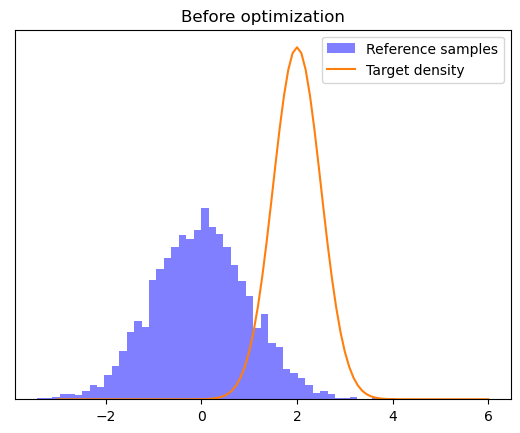

In [4]:
plt.figure()
plt.hist(x.flatten(), bins="auto", facecolor='blue', alpha=0.5, density=True, label='Reference samples')
plt.plot(t, rho_t,label="Target density")
plt.yticks([])
plt.legend()
plt.title("Before optimization")
plt.show()

Next we create a multi-index set and create a map. Affine transform should be enough to capture the Gaussian target.

In [5]:
multis = np.array([[0], [1]])  # 
mset = mt.MultiIndexSet(multis)
fixed_mset = mset.fix(True)

Now we set the map options (default in this case) and initialize the map

In [6]:
opts = mt.MapOptions()
monotoneMap = mt.CreateComponent(fixed_mset, opts)

Next we optimize the coefficients of the map by minimizing the Kullback–Leibler divergence between the target and reference density.

In [7]:
def objective(coeffs, monotoneMap, x, rv):
    num_points = x.shape[0]
    monotoneMap.SetCoeffs(coeffs)
    map_of_x = monotoneMap.Evaluate(x)
    pi_of_map_of_x = rv.logpdf(map_of_x)
    log_det = monotoneMap.LogDeterminant(x)
    return -np.sum(pi_of_map_of_x + log_det)/num_points

def obj(coeffs, transport_map, x):
    transport_map.SetCoeffs(coeffs)
    map_of_x = transport_map.Evaluate(x)
    logpdf= target_logpdf(map_of_x)
    log_det = transport_map.LogDeterminant(x)
    return -np.sum(logpdf + log_det)/num_points

In [8]:
print('Starting coeffs')
print(monotoneMap.CoeffMap())
print('and error: {:.2E}'.format(objective(monotoneMap.CoeffMap(), monotoneMap, x, reference_density)))
res = minimize(objective, monotoneMap.CoeffMap(), args=(monotoneMap, x, reference_density), method="Nelder-Mead")
print('Final coeffs')
print(monotoneMap.CoeffMap())
print('and error: {:.2E}'.format(objective(monotoneMap.CoeffMap(), monotoneMap, x, reference_density)))

Starting coeffs
[0. 0.]
and error: 4.79E+04
Final coeffs
[ 2.00339937 -0.42810606]
and error: 7.08E+03


...and plot the results. 

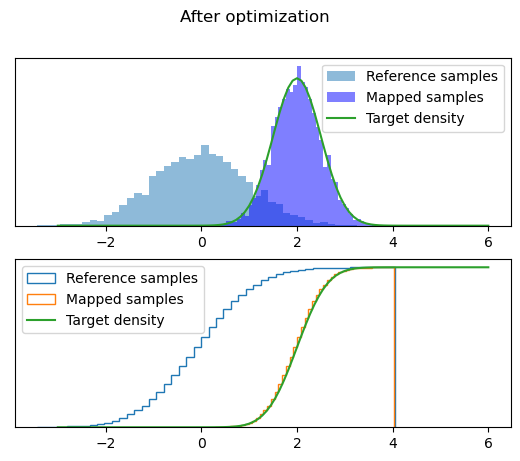

In [9]:
map_of_x = monotoneMap.Evaluate(x)
fig, axs = plt.subplots(2,1)
axs[0].hist(x.flatten(), bins="auto", alpha=0.5, density=True, label='Reference samples')
axs[0].hist(map_of_x.flatten(), bins="auto", facecolor='blue', alpha=0.5, density=True, label='Mapped samples')
axs[0].plot(t,rho_t,label="Target density")
axs[0].legend()
axs[0].set_yticks([])

axs[1].hist(x.flatten(), bins="auto", density=True, label='Reference samples', cumulative=True, histtype='step')
axs[1].hist(map_of_x.flatten(), bins="auto", density=True, label='Mapped samples', cumulative=True, histtype='step')
axs[1].plot(t, reference_density.cdf(t), label='Target density')
axs[1].legend()
axs[1].set_yticks([])

fig.suptitle("After optimization")

plt.show()